In [1]:
using ITensors

In [2]:
"""
Synthesize two MPO as M2 * M1.
When using the synthesized MPO, M1 will be applied to a MPS first, then M2.
"""

#Not used
#function synthesize(M1::MPO, M2::MPO)
#    M21 = contract(prime(M2), M1)
#    prime(M21, -1, plev=2) # -1? plev=2?
#end

#use apply

"Synthesize two MPO as M2 * M1.\nWhen using the synthesized MPO, M1 will be applied to a MPS first, then M2.\n"

In [3]:
function ITensors.op(::OpName"CPHASE2", ::SiteType"Qubit"; ϕ::Number)
    return [
      1 0 0 0
      0 1 0 0
      0 0 1 0
      0 0 0 exp(im * 2π *ϕ)
    ]
  end
  ITensors.op(::OpName"Cphase2", t::SiteType"Qubit"; kwargs...) = op("CPHASE2", t; kwargs...)

  # https://github.com/ITensor/ITensors.jl/blob/main/src/physics/site_types/qubit.jl

## QFT FUNCTION
### 繰り返し圧縮をする場合 

In [64]:
#  One Controled Phase gate
# controled がかかっていない量子ビットには、Identityを作用させる。
function CP(sites, a, b, phase)
    nqubit = length(sites)
    cp = op("CPHASE2", sites, a, b; ϕ=1/2^(phase))
    for i in 1:nqubit #[1,2]から1,2を抜いた配列
        if i == a || i == b
            continue
        end
        #@show i
        cp *= op("Id", sites, i)
    end
    return cp
end

# layer1 のcontroled phase gate ######
function MakeOneBlockQFT(sites, offset; cutoffcp::Float64=1e-14) #offsetは,Hがかかる位置
    nqubit = length(sites)
    block = MPO(Op("H", offset), sites) 
    for i in range(1, nqubit-offset) #EX)nqubit=2, offset=1
        # range(1, 0)の場合for分の中で何も起こらないことを利用している。
        phase = i+1
        cp = CP(sites, i+offset, offset, phase) #phase=2,3,4,5,6,,,　#layerをここにする。
        cp = MPO(cp, sites)
        @show (nqubit, maximum([dim(commoninds(cp[n], cp[n+1])[1]) for n in 1:(nqubit-1)]) )
        block = apply(cp, block; cutoff=cutoffcp)
        @show (nqubit, maximum([dim(commoninds(block[n], block[n+1])[1]) for n in 1:(nqubit-1)]) )
    end
    #@show maximum([dim(commoninds(block[n], block[n+1])[1]) for n in 1:(nqubit-1)])
    return block
end

function ExecFullQFT(sites; cutoffcp::Float64=1e-14, cutoffblock::Float64=1e-20)
    nqubit = length(sites)
    fullqft = MPO(Op("Id", 1), sites) #Dummy
    for offset in range(1, nqubit)
        qftblock = MakeOneBlockQFT(sites, offset; cutoffcp=cutoffcp)
        fullqft = apply(qftblock, fullqft; cutoff=cutoffblock)
    end
    return fullqft
end

ExecFullQFT (generic function with 1 method)

In [66]:
nbits_all = collect(2:10)
bonddims = Int[]
for nbits_ in nbits_all
    m = ExecFullQFT(siteinds("Qubit", nbits_); cutoffcp=1e-20, cutoffblock=1e-20)
    push!(bonddims, maximum([dim(commoninds(m[n], m[n+1])[1]) for n in 1:(nbits_-1)]))
end

#maximum(linkdims(M))
#maximum([dim(commoninds(m[n], m[n+1])[1])

(nqubit, maximum([dim((commoninds(cp[n], cp[n + 1]))[1]) for n = 1:nqubit - 1])) = (2, 4)
(nqubit, maximum([dim((commoninds(block[n], block[n + 1]))[1]) for n = 1:nqubit - 1])) = (2, 2)
(nqubit, maximum([dim((commoninds(cp[n], cp[n + 1]))[1]) for n = 1:nqubit - 1])) = (3, 4)
(nqubit, maximum([dim((commoninds(block[n], block[n + 1]))[1]) for n = 1:nqubit - 1])) = (3, 2)
(nqubit, maximum([dim((commoninds(cp[n], cp[n + 1]))[1]) for n = 1:nqubit - 1])) = (3, 4)
(nqubit, maximum([dim((commoninds(block[n], block[n + 1]))[1]) for n = 1:nqubit - 1])) = (3, 2)
(nqubit, maximum([dim((commoninds(cp[n], cp[n + 1]))[1]) for n = 1:nqubit - 1])) = (3, 4)
(nqubit, maximum([dim((commoninds(block[n], block[n + 1]))[1]) for n = 1:nqubit - 1])) = (3, 2)
(nqubit, maximum([dim((commoninds(cp[n], cp[n + 1]))[1]) for n = 1:nqubit - 1])) = (4, 16)
(nqubit, maximum([dim((commoninds(block[n], block[n + 1]))[1]) for n = 1:nqubit - 1])) = (4, 2)
(nqubit, maximum([dim((commoninds(cp[n], cp[n + 1]))[1]) for n = 1:nq

In [61]:
using Revise
using PyPlot

In [62]:
bonddims

6-element Vector{Int64}:
 2
 2
 4
 4
 8
 8

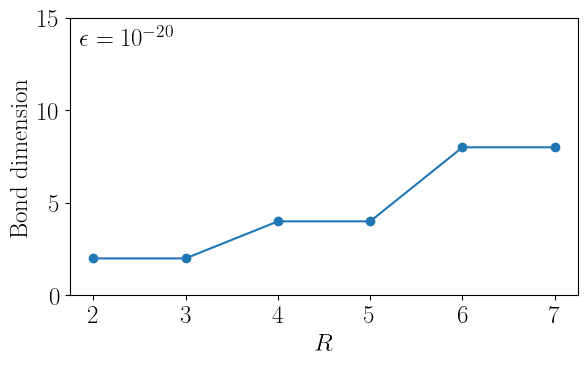

In [63]:
fig = figure(figsize=(6.4, 4.0))

annotate(L"\epsilon=10^{-20}", xycoords="axes fraction", xy=(0.02, 0.9), fontsize=18)
plot(nbits_all, bonddims, marker="o")
xlabel(L"R")
ylabel("Bond dimension")
ylim([0, 15])

tight_layout()

savefig("ft_bonddim_R$nbits.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())

In [8]:
function replace_mpo_siteinds!(M::MPO, sites_src, sites_dst)
    sites_src = noprime(sites_src) # noprimeでprime level set to zero.
    sites_dst = noprime(sites_dst)
    for j in eachindex(M)
        replaceind!(M[j], sites_src[j], sites_dst[j])
        replaceind!(M[j], sites_src[j]', sites_dst[j]')
    end
    return M
end

replace_mpo_siteinds! (generic function with 1 method)

In [9]:
# test for replace_mpo_siteinds!
nbit = 3
sites = siteinds("Qubit", nbit)
@show sites
M = MPO(sites, ["Y" for n in 1:nbit])
@show M
sites2 = [Index(2, "n=$n") for n in 1:nbit]
@show sites2
replace_mpo_siteinds!(M, sites, sites2)
@assert all([!hasind(M[n], sites[n]) for n in 1:nbit])
@show sites[1]'
@assert all([!hasind(M[n], sites[n]') for n in 1:nbit])
@assert all([hasind(M[n], sites2[n]) for n in 1:nbit])
@assert all([hasind(M[n], sites2[n]') for n in 1:nbit])

sites = Index{Int64}[(dim=2|id=855|"Qubit,Site,n=1"), (dim=2|id=112|"Qubit,Site,n=2"), (dim=2|id=832|"Qubit,Site,n=3")]
M = MPO
[1] ((dim=2|id=855|"Qubit,Site,n=1")', (dim=2|id=855|"Qubit,Site,n=1"), (dim=1|id=366|"Link,l=1"))
[2] ((dim=2|id=112|"Qubit,Site,n=2")', (dim=2|id=112|"Qubit,Site,n=2"), (dim=1|id=932|"Link,l=2"), (dim=1|id=366|"Link,l=1"))
[3] ((dim=2|id=832|"Qubit,Site,n=3")', (dim=2|id=832|"Qubit,Site,n=3"), (dim=1|id=932|"Link,l=2"))

sites2 = Index{Int64}[(dim=2|id=415|"n=1"), (dim=2|id=692|"n=2"), (dim=2|id=523|"n=3")]
(sites[1])' = (dim=2|id=855|"Qubit,Site,n=1")'


In [10]:
function _QFT(sites; cutoffcp::Float64=1e-14, cutoffblock::Float64=1e-20, inputorder=normal)
    M = ExecFullQFT(sites; cutoffcp=cutoffcp, cutoffblock=cutoffblock)
    M *= 2.0^(-0.5 * length(sites))
    if inputorder == :normal
        M = MPO([M[n] for n in length(M):-1:1]) #一番左がメッシュの小さい桁の数に直している？（どこでもとの順序に直している？）
        replace_mpo_siteinds!(M, reverse(sites), sites)
    end
    return M
end

_QFT (generic function with 1 method)

In [11]:
function forwardmpo(ftcore::FTCore, sites; inputorder=:normal)
    inputorder ∈ [:normal, :reversed] || error("Invalid inputorder")

    if inputorder == :normal
        M = copy(ftcore.forward)
        replace_mpo_siteinds!(M, extractsites(M), sites)
        return M
    else
        error("Not implemented yet")
    end
end

LoadError: UndefVarError: FTCore not defined

## test

## 1量子ビットQFT

In [12]:
## check
nqubit = 1
sites = siteinds("Qubit", nqubit)  
psi = MPS(sites, ["0"]) 
qft_1 = ExecFullQFT(sites; cutoffcp=1e-14, cutoffblock=1e-20)
qft_1_mpo = apply(qft_1, psi; cutoff=1e-20) 
qft_1_arr = Array(reduce(*, qft_1_mpo), sites)
@show qft_1_arr

## test
nqubit = 1 
sites = siteinds("Qubit", nqubit)  
layer1 = MPO(Op("H", 1), sites)
psi = MPS(sites, ["0"]) 
res = apply(layer1, psi) 
res_arr = Array(reduce(*, res), sites)

@assert qft_1_arr == res_arr

qft_1_arr = [0.7071067811865475, 0.7071067811865475]


## 2量子ビット

In [13]:
## check
nqubit = 2
sites = siteinds("Qubit", nqubit)  
psi = MPS(sites, ["1","1"]) 
qft_2 = ExecFullQFT(sites)
qft_2_mpo = apply(qft_2, psi; cutoff=1e-20) 
qft_2_arr = Array(reduce(*, qft_2_mpo), sites)
@show qft_2_arr

## test
nqubit = 2 
sites = siteinds("Qubit", nqubit)  
psi = MPS(sites, ["1", "1"]) 
# Create H_1
h1 = MPO(Op("H", 1), sites)
res = apply(h1, psi; cutoff=1e-20) 
# Create CR(2,1)
cp12 = op("CPHASE2", sites, 2,1; ϕ=(1/2^2))
cp12 = MPO(cp12, sites)
res = apply(cp12, res; cutoff=1e-20) 

h2 = MPO(Op("H", 2), sites)
res = apply(h2, res; cutoff=1e-20) 
res_arr = Array(reduce(*, res), sites)
@show res_arr
@assert isapprox(res_arr, qft_2_arr)
#@assert res_arr == qft_2_arr

qft_2_arr = ComplexF64[0.4999999999999999 - 1.6269787532313372e-16im -0.4999999999999999 + 1.8110545273503293e-16im; 6.182246798045963e-17 - 0.5im -4.3414890568560417e-17 + 0.5im]
res_arr = ComplexF64[0.4999999999999996 - 7.850462293418873e-17im -0.4999999999999996 + 7.850462293418873e-17im; 7.850462293418873e-17 - 0.4999999999999998im -7.850462293418873e-17 + 0.4999999999999998im]


## Blockごとに圧縮をかける方法

In [14]:
## check
nqubit = 2
sites = siteinds("Qubit", nqubit)  
psi = MPS(sites, ["1","1"]) 
qft_2 = ExecFullQFT(sites)
qft_2_mpo = apply(qft_2, psi; cutoff=1e-20) 
qft_2_arr = Array(reduce(*, qft_2_mpo), sites)
@show qft_2_arr

## test
nqubit = 2 
sites = siteinds("Qubit", nqubit)  
psi = MPS(sites, ["1", "1"]) 
# Create H_1
h1 = MPO(Op("H", 1), sites)
#res = apply(h1, psi; cutoff=1e-20) 
# Create CR(2,1)
cp12 = op("CPHASE2", sites, 2,1; ϕ=(1/2^2))
cp12 = MPO(cp12, sites)
layer1 = apply(cp12, h1)
res = apply(layer1, psi; cutoff=1e-20) 
h2 = MPO(Op("H", 2), sites)
res = apply(h2, res; cutoff=1e-20) 
res_arr = Array(reduce(*, res), sites)
@show res_arr
@assert isapprox(res_arr, qft_2_arr)
#@assert res_arr == qft_2_arr

qft_2_arr = ComplexF64[0.4999999999999999 - 1.6269787532313372e-16im -0.4999999999999999 + 1.8110545273503293e-16im; 6.182246798045963e-17 - 0.5im -4.3414890568560417e-17 + 0.5im]
res_arr = ComplexF64[0.4999999999999998 - 1.3842737727467785e-16im -0.4999999999999998 + 1.3842737727467785e-16im; 4.246865884799244e-17 - 0.49999999999999983im -4.246865884799244e-17 + 0.49999999999999983im]


## 3量子ビット

In [15]:
## check
nqubit = 3
sites = siteinds("Qubit", nqubit)  
psi = MPS(sites, ["0","0","1"]) 
qft_3 = ExecFullQFT(sites)
qft_3_mpo = apply(qft_3, psi; cutoff=1e-20) 
qft_3_arr = Array(reduce(*, qft_3_mpo), sites)
@show qft_3_arr


##test
nqubit = 3
sites = siteinds("Qubit", nqubit) 

# layer1
h1 = MPO(Op("H", 1), sites)
cp12 = op("CPHASE2", sites, 2,1; ϕ=(1/2^2)) * op("Id", sites, 3)
cp12 = MPO(cp12, sites)
cp13 = op("CPHASE2", sites, 3,1; ϕ=(1/2^3)) * op("Id", sites, 2)
cp13 = MPO(cp13, sites)
layer1 = apply(cp12, h1) # H_1 
layer1 = apply(cp13, layer1)
h2 = MPO(Op("H", 2), sites)
cp23 = op("CPHASE2", sites, 3,2; ϕ=(1/2^2)) * op("Id", sites, 1)
cp23 = MPO(cp23, sites)
layer2 = apply(cp23, h2)
#layer3
layer3 = MPO(Op("H", 3), sites)
layer12 = apply(layer2, layer1)
layer123 = apply(layer3, layer12)
psi = MPS(sites, ["0", "0", "1"]) 
res = apply(layer123, psi; cutoff=1e-20) 
res_arr = Array(reduce(*, res), sites) #c_{ijk}
#@assert isapprox(res_arr, 1/sqrt(2)^3 .* [1.0 1.0; 1.0 1.0 ;;; 1.0 1.0; 1.0 1.0])
#@assert res_arr == qft_3_arr
@assert isapprox(res_arr, qft_3_arr)

qft_3_arr = [0.3535533905932724 + 7.181611006084304e-17im 6.681653774269991e-17 + 0.3535533905932728im; 0.24999999999999967 + 0.2499999999999992im -0.24999999999999936 + 0.24999999999999994im;;; -0.35355339059327257 - 1.218918054692504e-16im -2.884225815018681e-17 - 0.35355339059327273im; -0.24999999999999967 - 0.24999999999999925im 0.24999999999999933 - 0.24999999999999986im]


## G($\tau$) のMPS表示


In [16]:
using Revise
using PyPlot
using LaTeXStrings
using PyCall

using LinearAlgebra
using SparseIR
import SparseIR: valueim

In [17]:
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 18
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.serif"] = ["Computer Modern Roman"]

1-element Vector{String}:
 "Computer Modern Roman"

In [18]:
BLAS.set_num_threads(16)

In [19]:
println(Threads.nthreads())

1


In [20]:
using ITensors
ITensors.disable_warn_order()
println(ITensors.blas_get_num_threads())

16


In [21]:
nbits = 24
sites = siteinds("Qubit", nbits)
β = 100.0
ω = 1.0
2^nbits

16777216

In [22]:
function gtaumps(sites, β, ω)
    nbits = length(sites)
    m = MPS(ComplexF64, sites, linkdims=1)
    linkinds = [commoninds(m[n], m[n+1])[1] for n in 1:(nbits-1)]    #https://docs.juliahub.com/ITensors/P3pqL/0.2.1/ITensorType.html#ITensors.commoninds
    elem(n, t) = exp(-(t-1) * β *  ω * 2.0^(-n))
    for n in 1:nbits
        if n == 1
            for t in 1:2
                m[n][linkinds[n]=>1, sites[n]=>t] = elem(n, t)
            end
        elseif n == nbits
            for t in 1:2
                m[n][linkinds[n-1]=>1, sites[n]=>t] = elem(n, t)
            end
        else
            for t in 1:2
                m[n][linkinds[n-1]=>1, linkinds[n]=>1, sites[n]=>t] = elem(n, t)
            end
        end
    end
    return (-1/(1 + exp(-β * ω))) * m
end

gtaumps (generic function with 1 method)

In [23]:
mgtau = gtaumps(sites, β, ω);

In [24]:
gtau_reconst = vec(Array(reduce(*, mgtau), reverse(sites)));

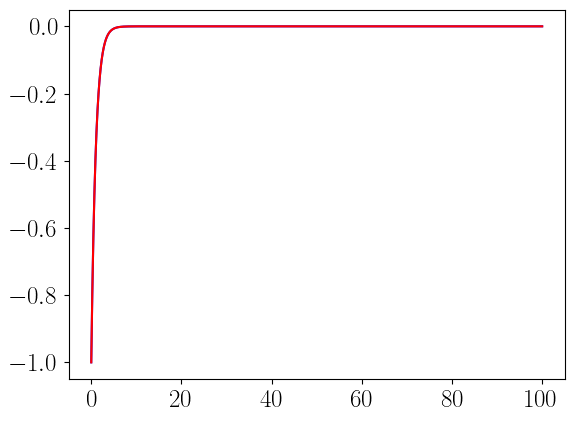

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3d8c2f100>

In [25]:
tau = LinRange(0.0, β, 2^nbits+1)[1:end-1]
plot(tau, real.(gtau_reconst),color="b")
gtaufunc(τ) = - exp(- ω * τ) / (1 + exp(- ω * β))
plot(tau, gtaufunc.(tau),color="r")

In [26]:
@assert real.(gtau_reconst) ≈ gtaufunc.(tau) # test!

Util